## Scratchpad to use for Dive into Deep Learning (D2L) book
Using this as scratchpad to teach

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
# Use apple silicon mps
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:
device = mps_device
print(device)

mps


## Torch autograd - L2

In [4]:
a = torch.tensor([2., 3], requires_grad=True)
b = torch.tensor([6., 4], requires_grad=True)

In [5]:
Q = 3*a**3 - b**2

In [6]:
external_grad = torch.tensor([1., 1])
Q.backward(gradient=external_grad)

In [7]:
print(a.grad, b.grad)

tensor([36., 81.]) tensor([-12.,  -8.])


In [8]:
a.grad.zero_()
b.grad.zero_()

tensor([0., 0.])

In [9]:
Q = 3*a**3 - b**2
external_grad = torch.tensor([1., 0])
Q.backward(gradient=external_grad) # J.T * v

In [10]:
print(a.grad, b.grad)

tensor([36.,  0.]) tensor([-12.,   0.])


## Building blocks - L3

In [11]:
from torch.utils import data

def synthesize_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = X @ w + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2., -3.4])
true_b = 4.2
features, labels = synthesize_data(true_w, true_b, 1000)
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [12]:
def load_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [13]:
batch_size = 10
data_iter = load_data((features, labels), batch_size)

In [14]:
from torch import nn

net = nn.Sequential(
    nn.Linear(2, 1)
)
net[0].weight, net[0].bias

(Parameter containing:
 tensor([[-0.1959, -0.5737]], requires_grad=True),
 Parameter containing:
 tensor([-0.3736], requires_grad=True))

In [15]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)
net[0].weight, net[0].bias

(Parameter containing:
 tensor([[-0.0063,  0.0041]], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True))

In [16]:
loss = nn.MSELoss()
optim = torch.optim.SGD(net.parameters(), lr=0.02)

In [17]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        optim.zero_grad()
        
        l = loss(net(X), y)
        l.backward()
        optim.step()
    l = loss(net(features), labels)
    print(f'epoch -> {epoch + 1} with loss -> {l:f}')
        

epoch -> 1 with loss -> 0.009543
epoch -> 2 with loss -> 0.000105
epoch -> 3 with loss -> 0.000102


In [18]:
w = net[0].weight.data
print(abs(true_w - w.reshape(true_w.shape)))

tensor([2.2531e-05, 1.6689e-05])


In [19]:
b = net[0].bias.data
print(abs(true_b - b))

tensor([0.0001])


## L4

In [20]:
net = nn.Sequential(
    nn.Linear(2, 4),
    nn.Linear(4, 1)
)
X = torch.rand(3, 2)
net(X)

tensor([[0.7657],
        [1.1250],
        [0.9059]], grad_fn=<AddmmBackward0>)

In [21]:
net[0].state_dict()

OrderedDict([('weight',
              tensor([[-0.6436,  0.2146],
                      [ 0.6018,  0.2799],
                      [-0.3443, -0.0851],
                      [-0.6666,  0.6326]])),
             ('bias', tensor([ 0.0278,  0.5734, -0.3558, -0.3736]))])

In [22]:
net[1].state_dict()

OrderedDict([('weight', tensor([[-0.3705,  0.4034, -0.0035, -0.4339]])),
             ('bias', tensor([0.3543]))])

In [23]:
for name, param in net.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[-0.6436,  0.2146],
        [ 0.6018,  0.2799],
        [-0.3443, -0.0851],
        [-0.6666,  0.6326]], requires_grad=True)
0.bias Parameter containing:
tensor([ 0.0278,  0.5734, -0.3558, -0.3736], requires_grad=True)
1.weight Parameter containing:
tensor([[-0.3705,  0.4034, -0.0035, -0.4339]], requires_grad=True)
1.bias Parameter containing:
tensor([0.3543], requires_grad=True)


In [24]:
def blk1():
    return nn.Sequential(
        nn.Linear(4, 8),
        nn.ReLU(),
        nn.Linear(8, 4),
        nn.ReLU()
    )
    
def blk2():
    net = nn.Sequential()
    for i in range(2):
        net.add_module(f'blk_{i}', blk1())
    return net

In [25]:
blk_net = nn.Sequential(
    blk2(),
    nn.Linear(4, 1)
)
print(blk_net)

Sequential(
  (0): Sequential(
    (blk_0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (blk_1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


## L5

In [26]:
def init_weights_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)

print(net)
net.apply(init_weights_normal)
net[0].weight.data[0], net[0].bias.data[0]

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=1, bias=True)
)


(tensor([-0.0171, -0.0123]), tensor(0.))

### Load and save params

```
torch.save(net.state_dict(), 'name')
```
```
clone = Net()
clone.load_state_dict(torch.load('name'))
```

## L7

In [143]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [144]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))


In [145]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05
train_data = synthetic_data(true_w, true_b, n_train)
test_data = synthetic_data(true_w, true_b, n_test)

In [146]:
print(train_data[0].shape, train_data[1].shape)

torch.Size([20, 200]) torch.Size([20, 1])


In [147]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [148]:
train_iter = load_data(train_data, batch_size)
test_iter = load_data(test_data, batch_size, is_train=False)

In [149]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [150]:
def forward(X, w, b):
    return torch.matmul(X, w) + b

In [151]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [152]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
    

In [153]:
def eval_loss(net, data_iter, loss):
    l = 0
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l += loss(out, y).sum()
    return l

def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

def l1_penalty(w):
    return torch.sum(torch.abs(w))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 866.42it/s]


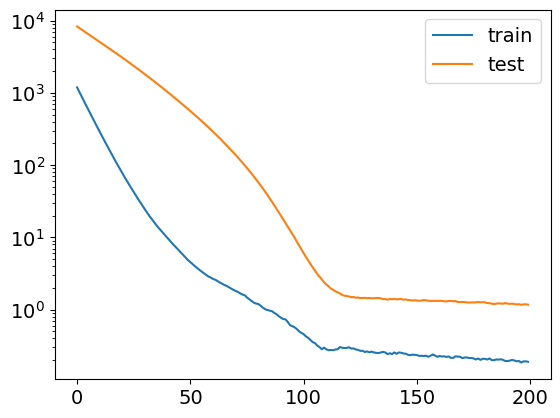

In [156]:
w, b = init_params()
num_epochs, lr = 200, 0.001
alpha = 5
beta = 1
net = lambda X: forward(X, w, b)
train_loss = np.zeros(num_epochs)
test_loss = np.zeros(num_epochs)

for epoch in tqdm(range(num_epochs)):
    for X, y in train_iter:
        #l = squared_loss(net(X), y)
        #l = squared_loss(net(X), y) + alpha * l2_penalty(w)
        l = squared_loss(net(X), y) + alpha * l2_penalty(w) + beta * l1_penalty(w)
        l.sum().backward() # sgd uses the computed grad
        sgd([w, b], lr, batch_size)
        
    with torch.no_grad():
        train_loss[epoch] = eval_loss(net, train_iter, squared_loss)
        test_loss[epoch] = eval_loss(net, test_iter, squared_loss)

plt.rcParams.update({'font.size': 14})
plt.plot(np.arange(num_epochs), train_loss, label='train')
plt.plot(np.arange(num_epochs), test_loss, label='test')
plt.legend()
plt.yscale('log')